In [ ]:
import abc
import pathlib
import numpy as np
import pandas as pd

data_dir = pathlib.Path('examples').resolve()
calc_dir = data_dir / 'calc'
log = calc_dir / 'casscf.log'
fchk = log.with_suffix('.fchk')

In [2]:
from mctools.core.resources import Resources
from mctools.parsing.gaussian.log.route import Link
from mctools.parsing.gaussian.log import LogParser

parser = LogParser()
data = parser.parse(log)

Initializing: LogParser Sequential
Initializing: LogParser CompositeParser
Initializing: LogParser Base
LogParser(parsers=[RouteParser,LinksParser], storage=, parser_params={}, on_parsing_error='raise'): Given PosixPath('/Users/kirill/Documents/UW/Li_Group/mctools/examples/calc/casscf.log')
LogParser(parsers=[RouteParser,LinksParser], storage=, parser_params={}, on_parsing_error='raise'): Parsing
LogParser(parsers=[RouteParser,LinksParser], storage=, parser_params={}, on_parsing_error='raise'): Building 'RouteParser'
Initializing: RouteParser File
Initializing: RouteParser Base
LogParser(parsers=[RouteParser,LinksParser], storage=, parser_params={}, on_parsing_error='raise'): Done building  RouteParser(stepper=BaseFileStepper(file=None), on_parsing_error='raise')
RouteParser(stepper=BaseFileStepper(file=None), on_parsing_error='raise'): Given <_io.TextIOWrapper name='/Users/kirill/Documents/UW/Li_Group/mctools/examples/calc/casscf.log' mode='rt' encoding='UTF-8'>
RouteParser(stepper=Ba

In [3]:
k = list(data[-1][Link.L302].keys())[0]

In [6]:
array = data[-1][Link.L302][Resources.ao_int1e_overlap]

In [10]:
dim = 575

tril = np.tril_indices(575)
matrix = np.zeros((dim, dim))
matrix[tril] = array

In [14]:
m1 = (matrix + matrix.T - matrix.diagonal()).copy()
m2 = matrix.copy()

m2 += m2.T - m2.diagonal()

True

In [3]:
import numpy as np
from mctools.parsing.core import ProcessedPattern

def process_data_type(char: str, /):
    match char:
        case 'R':
            return np.float_
        case 'I':
            return np.int_
        case 'C':
            return np.str_
        case _:
            raise ValueError(f'Invalid data_type: {char}')
        
FCHK_HEADER_PATT = ProcessedPattern(
    r'(?P<header>([A-Z][a-zA-Z]+)(\s[a-zA-Z]+)+)\s+'
    r'(?P<dtype>[IRCHL])\s+'
    r'((N=\s+(?P<size>\d+))|(?P<value>[+-]?\d+(\.\d+[dDeE]\+\d+)?))',
    constructor='header',
    group_maps={
        'size': lambda s: int(s) if s else s,
        'dtype': process_data_type,
    },
    match_funcs={
        'value': lambda m: (int(m.pop('value')) if m['size'] else m['dtype'](m.pop('value'))) if m['value'] else None
    }
)

scalar1 = 'Number of electrons                        I              391'
scalar2 = 'SCF Energy                                 R     -5.674493527405919E+04'
array = 'Nuclear charges                            R   N=           7'
headers = [scalar1, scalar2, array]


for h in headers:
    print(h)
    if match := FCHK_HEADER_PATT.match(h):
        print(match)

Number of electrons                        I              391
header(header='Number of electrons', dtype=<class 'numpy.int64'>, size=None, value=391)
SCF Energy                                 R     -5.674493527405919E+04
header(header='SCF Energy', dtype=<class 'numpy.float64'>, size=None, value=-56744.93527405919)
Nuclear charges                            R   N=           7


ValueError: invalid literal for int() with base 10: 'None'

In [35]:
|int('')

ValueError: invalid literal for int() with base 10: ''

In [ ]:
from typing import IO, AnyStr, Any

from mctools.parsing.gaussian.log.l1 import Link, Route
from mctools.parsing.core import BaseFileParser, ListeningFileParser, FileParser


class LinkParser(FileParser, metaclass=abc.ABCMeta):
    pass




In [5]:
from mctools.parsing.gaussian.log.l1 import Link
f'{Link.L910}'

'l910'

In [1]:
from mctools.parsing.gaussian import LogParser

parser = LogParser()
data = parser.parser(log, int1e=['stv'])

NameError: name 'Predicate' is not defined

In [10]:
from mctools.parsing.gaussian import FchkParser

with fchk.open('r', encoding='ascii') as f:
    parser = FchkParser()
    data = parser.parse(f)

basis_info = data[FchkParser.options_cls.basis]
basis = basis_info['basis']
shells = basis_info['shells']
prims = basis_info['prims']
aos = basis.df.copy()

n_inactive = 342
n_active = 50
molorb = data[FchkParser.options_cls.molecular_orbitals]
active_space = np.s_[n_inactive:n_inactive + n_active]
actorb = molorb[active_space]
# mos = basis.partition_molorb(actorb, by=['element', 'l']) 

atom_idx, shell_idx = 0, 0

In [11]:
prims

,C,alpha,shell
0,0.000747,3.285856e+07,0
1,0.002137,5.434999e+06,0
2,0.005152,1.189227e+06,0
3,0.011945,3.044478e+05,0
4,0.027523,8.748498e+04,0
...,...,...,...
445,1.000000,1.356267e+01,176
446,1.000000,6.652201e-01,177
447,1.000000,1.700000e-01,178
448,1.000000,2.180000e+00,179


In [62]:
import pathlib
import time
import numpy as np

from tqdm import tqdm

from mctools.parsing import FileStepper
from mctools.parsing.gaussian.log.utils import MatrixParserMixin


data_dir = pathlib.Path('examples').resolve()
calc_dir = data_dir / 'calc'

fchk =  calc_dir / 'casscf.fchk'
log = fchk.with_suffix('.log')

line_to_data = lambda l: l.strip().replace('D', 'E').split()


def read_wrapped_matrix(stepper: FileStepper, header: str, dtype=float):
    stepper.step_skip_until(header) 
    
    is_data_row = lambda l: '.' in l
    is_header_row = lambda l: not is_data_row(l)
    
    array = []
    dim_size = 0
    n_cols_per_blocks = len(stepper.readline().strip().split())
    
    while '.' in (line := stepper.readline()):
        row = line.strip().replace('D', 'E').split()
        array.extend(map(float, row[1:]))
        dim_size += 1

    n_elems = (dim_size * dim_size - dim_size) // 2  + dim_size 
    for j in range(n_cols_per_blocks, dim_size, n_cols_per_blocks):
        for i in range(j, dim_size):
            row = stepper.readline().strip().replace('D', 'E').split()
            array.extend(map(dtype, row[1:]))
        
        if len(array) < n_elems:
            stepper.readline()
        else:
            break
    return array

# header = 'Overlap'
# dim = 575


n_states = 50

n_mo_act = 50
rdm_shape = (n_mo_act, n_mo_act)
header_real = '1PDM Matrix (real) :'
header_imag = '1PDM Matrix (imag) :'

array = []

times = []
with log.open('r') as f:
    parser = MatrixParserMixin()
    parser.set_file(f)

    for i in tqdm(range(n_states)):
        parser.step_skip_until(header_real) 
        
        t0 = time.perf_counter_ns()
        parser.read_rectangular(*rdm_shape, array=array)
        t1 = time.perf_counter_ns()
        times.append(t1 - t0)
        
        parser.step_skip_until(header_imag) 
        
        t0 = time.perf_counter_ns()
        parser.read_rectangular(*rdm_shape, array=array)
        t1 = time.perf_counter_ns()
        times.append(t1 - t0)

times = np.asarray(times)
print(times.mean(), times.std())

100%|██████████| 50/50 [00:00<00:00, 141.29it/s]

385524.64 23005.608231698636


In [80]:
rdms_32 = np.asarray(array, dtype=np.float32).reshape((n_states, 2, n_mo_act, n_mo_act))
rdms_32 = np.moveaxis(rdms_32, 1, -1, ).copy()
rdms_32 = rdms_32.view(np.complex64).squeeze()

In [81]:
rdms_64 = np.asarray(array, dtype=np.float64).reshape((n_states, 2, n_mo_act, n_mo_act))
rdms_64 = np.moveaxis(rdms_64, 1, -1, ).copy()
rdms_64 = rdms_64.view(np.complex128).squeeze()

In [65]:
import re
 CI Transition Density Matrix     1 :     3
 Compute 1PDM now
 1TDM Matrix:                       1
header = 'Oscillator Strength For States      1 :      2 f=    0.000000'
header = 'Computing Spin expectation values.'
l = 'State:           1  <Sx>=  0.1340 <Sy>=  0.0000 <Sz>=  0.0823 <Sx**2>=  0.2623 <Sy**2>=  0.2623 <Sz**2>=  0.2624 <S**2>=  0.7870 S=  0.5183'

 Computing Spin expectation values.

 Computing Spin expectation values.
 State:           1  <Sx>=  0.1340 <Sy>=  0.0000 <Sz>=  0.0823 <Sx**2>=  0.2623 <Sy**2>=  0.2623 <Sz**2>=  0.2624 <S**2>=  0.7870 S=  0.5183
 
 Using Dipole Ints in file:                     872
 CI Transition Density Matrix     1 :     2
 Compute 1PDM now
 1TDM Matrix:                       1
 1TDM Matrix:                       2
 Oscillator Strength For States      1 :      2 f=    0.000000

In [74]:
%timeit list(map(float, l.split()[1::2][1:]))

858 ns ± 1.56 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [69]:
%timeit list(map(float, re.findall('\d+\.\d+', l)))

3.28 µs ± 860 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [76]:
3.28 * 1e3 / 858

3.8228438228438226

In [7]:
from mctools.parsing.gaussian.log.l302 import read_ao_overlap_matrix

n_checks = 10
times = np.zeros(n_checks)
for k in range(n_checks):
    with log.open('r') as f:

        t0 = time.perf_counter_ns()
        array = read_ao_overlap_matrix(f, first_line='')
        t1 = time.perf_counter_ns()
    
        times[k] = t1 - t0

print(times.mean() / 1e6, times.std() / 1e6) 

376.1994917 91.58350366712911


In [31]:
f = np.vectorize(lambda v: f'{v:e}')

strings = f(np.random.uniform(-1e-8, 1e8, 5000))
strings_lst = list(np.char.replace(strings, 'e', 'D'))

In [30]:
%timeit np.char.replace(strings, 'D', 'e').astype(np.float_)

3.81 ms ± 190 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [37]:
%timeit np.fromiter(map(lambda v: v.replace('D', 'e'), strings_lst), dtype=np.float_)

582 µs ± 927 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [12]:
dim_size

NameError: name 'dim_size' is not defined

In [23]:
import numpy as np

arr64 = np.asarray(array, dtype=np.float64)
arr32 = np.asarray(array, dtype=np.float32)

In [30]:
arr64.nbytes / 1024

1293.75

In [28]:
arr32.nbytes / 1024

646.875

# Analyze CAS States

In [9]:
from mctools.parser.gaussian import parse_gdvlog, l302_parser_funcs_general, l302_postprocess_general, l910_parser_funcs_fast

gdvlog = data_dir / 'casscf.log'

data = parse_gdvlog(
    gdvlog, 
    l302_parser_funcs_general | l910_parser_funcs_fast,
    postprocess_links=l302_postprocess_general
)

Reading /Users/kirill/Documents/UW/Li_Group/mctools/examples/casscf.log
Parsing link l302
Executing: read_ao_overlap_matrix --- Done
Executing: read_ao_kinetic_energy_matrix --- Done
Executing: read_ao_hcore_matrix --- Done
Parsing link l910
Executing: read_mc_spec --- Done
Executing: read_ci_vecs --- Done
Executing: read_rdm_diags --- Done
Skipping: read_oscillator_strength: positional parameter n_ground is unavailable


In [230]:
import mmap
import re

from collections import defaultdict
from typing import Callable, IO, AnyStr, Any

general_link_patt = re.compile(rb'^\s+((\(Enter|Entering Link)[\s\d=]+(?P<path>\/.*\.[\w:]+))', flags=re.MULTILINE)


def parse_general_link_path(path: str) -> str:
    return pathlib.Path(path).stem

def find_links_re(filename: str | pathlib.Path, *, parse_link_path: Callable[[str], str] | None = None) ->  dict[str, list[tuple[int, int | None]]]:
    parse_link_path = parse_general_link_path if parse_link_path is None else parse_link_path

    filesize: int
    found_links: list[tuple[str, int]] = []
    with pathlib.Path(filename).open(mode="r", encoding="ascii") as file_obj:
        with mmap.mmap(file_obj.fileno(), length=0, access=mmap.ACCESS_READ) as mmap_obj:
            filesize = int(mmap_obj.size())
            for match in general_link_patt.finditer(mmap_obj):
                link = parse_link_path(match.groupdict()['path'].decode())
                start = match.span(0)[0]
                found_links.append((link, start))
    
    links: dict[str, list[tuple[int, int | None]]] = defaultdict(list)
    for i, (path, start) in enumerate(found_links[:-1]):
        next_start = found_links[i + 1][1]
        links[path].append((start, next_start - start))
    else:
        path, start = found_links[-1]
        links[path].append((start, filesize - start))
        
    return links


def find_links(filename: str | pathlib.Path, include_l1: bool = False) ->  dict[str, list[tuple[int, int | None]]]:
    filesize = 0
    found_links: list[tuple[str, int]] = []
    with pathlib.Path(filename).open(mode="r", encoding="ascii") as file_obj:
        with mmap.mmap(file_obj.fileno(), length=0, access=mmap.ACCESS_READ) as mmap_obj:
            if include_l1:
                for line in iter(mmap_obj.readline, b""):
                    if line.startswith(b' Entering Link'):
                        link = line.strip().split()[4].rsplit(b'/', 1)[-1].split(b'.')[0].decode()
                        found_links.append((link, filesize))
                        filesize += len(line)
                        break
                    filesize += len(line)
                
            for line in iter(mmap_obj.readline, b""):
                if line.startswith(b' (Enter'):
                    link = line.strip().strip(b'()').rsplit(b'/', 1)[-1].split(b'.')[0].decode()
                    found_links.append((link, filesize))
                filesize += len(line)
    
    links: dict[str, list[tuple[int, int | None]]] = defaultdict(list)
    for i, (link, start) in enumerate(found_links[:-1]):
        next_start = found_links[i + 1][1]
        links[link].append((start, next_start - start))
    else:
        link, start = found_links[-1]
        links[link].append((start, filesize - start))
        
    return links


def parse_link(filename: str | pathlib.Path, offset: int, length: int) -> None:
    mmap_offset = (offset // mmap.ALLOCATIONGRANULARITY) * mmap.ALLOCATIONGRANULARITY
    link_offset = offset - mmap_offset
    mmap_length = link_offset + length
    
    with pathlib.Path(filename).open(mode="r", encoding="ascii") as f:
        with mmap.mmap(f.fileno(), length=mmap_length, access=mmap.ACCESS_READ, offset=mmap_offset) as mmap_obj:
            mmap_obj.seek(link_offset)
            for i, line in enumerate(iter(mmap_obj.readline, b"")):
                print(line.decode("utf-8").strip())

In [232]:
from mctools.core.mcspace import MCSpace
from mctools.parser.lib import ParsingResult

L910 = 'l910'

rout_patt = re.compile(r'^ *(\d+)\/(\d+=[-\d]+,?)+\/(\d,?)+;')

RouteType =  dict[str, list[dict[int, int]]] 
def parse_l1(filename: str | pathlib.Path) -> RouteType:
    route: RouteType = defaultdict(list)
    with pathlib.Path(filename).open(mode="r") as file_obj:
        for line in file_obj:
            if line.startswith(' Leave'):
                break
                
            if rout_patt.match(line):
                line = line.strip().strip(';')
                start, middle, ends = line.split('/')
                middle = {k: v for k, v in map(lambda p: tuple(map(int, p.split('='))), middle.split(','))}
                ends = [e.rjust(2, '0') for e in ends.split(',')]
                
                for end in ends: 
                    link = 'l' + start + end
                    route[link].append(middle)
    return route

def parse_l910_route(route: RouteType, route_idx: int = 0) -> tuple[bool, ParsingResult]:
    if L910 not in route:
        return False, ParsingResult()
    
    l910_route = route[L910][route_idx]
    
    n_elec = l910_route.get(6, 0)
    n_mos = l910_route.get(7, 0)
    max_hole = l910_route.get(111, 0)
    ras1_mo = l910_route.get(112, 0)
    max_elec = l910_route.get(113, 0)
    ras3_mo = l910_route.get(114, 0)
    ras2_mo = n_mos - ras1_mo - ras3_mo
    mcspace = MCSpace.from_space_spec(
        (ras1_mo, ras2_mo, ras3_mo), n_elec,
        max_hole=max_hole, max_elec=max_elec
    )
    
    n_states = l910_route.get(17, 1)
    n_states = n_states // 10000 + n_states % 10000  # Account for M0000, where M is number higher energy states in Davidson
    
    n_ground = l910_route.get(19, None)
    n_ground = n_states if n_ground and n_ground < 0 else n_ground
    
    has_rdms = l910_route.get(32, 1)
    has_rdms = has_rdms == 0 or has_rdms == 1
    
    has_tdms = bool(l910_route.get(131, 0)),
    
    return True, {
        'mcspace': mcspace,
        'n_states': n_states,
        'n_ground': n_ground,
        
        'has_rdms': has_rdms,
        'has_tdms': has_tdms,
        
        'n_mo_act': lambda _: mcspace.n_mo_act
    }

In [2]:
result = {}
build_l910_parser_funcs(route, result=result)

NameError: name 'build_l910_parser_funcs' is not defined

In [4]:
result

{'mcspace': MCSpace([49e50o|50o], #Det=50, #Cat=1),
 'n_states': 50,
 'n_ground': 0,
 'n_configs': <function mctools.io.gaussian.log.l910.parse_l910_link.<locals>.<lambda>(_)>,
 'n_mo_act': <function mctools.io.gaussian.log.l910.parse_l910_link.<locals>.<lambda>(_)>}

(True,
 {'mcspace': MCSpace([16e40o|-2/16, 0/ 0, 2/24], #Det=33,505, #Cat=3),
  'n_states': 33505,
  'n_ground': 1})

In [224]:
s1 = set((k,len(v)) for k, v in links.items())
s2 = set((k,len(v)) for k, v in route.items())
assert s1 == s2

defaultdict(list,
            {'l101': [{38: 1}],
             'l202': [{12: 2, 15: 3, 40: 1}],
             'l301': [{5: 7,
               6: 2,
               11: 9,
               25: 1,
               30: 1,
               60: -1,
               91: 6,
               116: 7,
               185: 14}],
             'l302': [{5: 7,
               6: 2,
               11: 9,
               25: 1,
               30: 1,
               60: -1,
               91: 6,
               116: 7,
               185: 14}],
             'l303': [{5: 7,
               6: 2,
               11: 9,
               25: 1,
               30: 1,
               60: -1,
               91: 6,
               116: 7,
               185: 14}],
             'l401': [{5: 1, 8: 1}],
             'l910': [{5: 2,
               6: 16,
               7: 40,
               10: 3,
               12: -1,
               13: 2,
               14: 8,
               15: 1000,
               17: 33505,
               19: 1,
  

In [8]:
cas_space = MCSpace.from_dict(data, max_hole=0, max_elec=0)
cas_states = MCStates.from_dict(data, mcspace=cas_space)

cas_space.set_mo_blocks({
    '4f': [(0, 13), 49],
    '5p': [(13, 49)]
})

cas_space.set_config_classes({
    'f13': {'4f': 13, '5p': 36},
    'Lf14': {'4f': 14, '5p': 35},
})

cas_states.analyze()

Reading casscf.log
Parsing link l302
Executing: read_ao_overlap_matrix --- Done
Executing: read_ao_kinetic_energy_matrix --- Done
Executing: read_ao_hcore_matrix --- Done
Executing: read_orthogonal_aos_matrix --- Done
Parsing link l910
Executing: read_mc_spec --- Done
Executing: read_ci_vecs --- Done
Executing: read_rdm_diags --- Done
Skipping: read_oscillator_strength: positional parameter n_ground is unavailable


In [9]:
cas_states.print_state(idx=[0, 1])

#    0: E =     -56745.3Eh
        MO: 4f(13.04) + 5p(35.96)
        |ψ> = f13(95.960%) + Lf14( 4.040%)
------------------------------------------------------------------------------------------------------------------------
 Addr                        CAS                                   Coefficient           
    41 11111111011111111111111111111111111111111111111111 C =  0.014-0.836j |C|^2 =  0.699
     0 11111111111111111111111111111111111111111111111110 C =  0.428+0.000j |C|^2 =  0.183
    39 11111111110111111111111111111111111111111111111111 C = -0.018+0.213j |C|^2 =  0.046
    37 11111111111101111111111111111111111111111111111111 C =  0.113+0.114j |C|^2 =  0.026
    10 11111111111111111111111111111111111111101111111111 C = -0.017+0.156j |C|^2 =  0.025
#    1: E =     -56745.3Eh
        MO: 4f(13.03) + 5p(35.97)
        |ψ> = f13(97.257%) + Lf14( 2.743%)
------------------------------------------------------------------------------------------------------------------------
 Addr

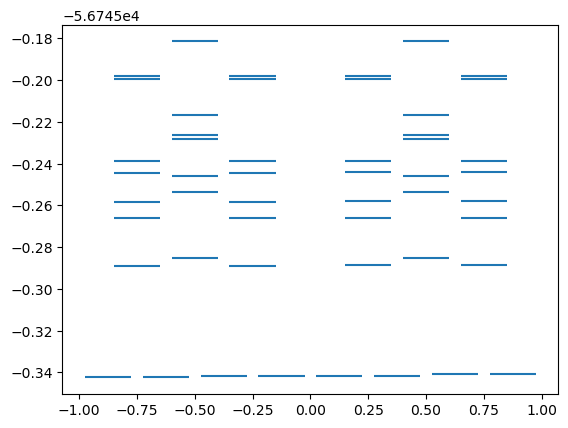

In [6]:
from mctools.plot.states import prepare_state_centers

width = 0.1
x_c = prepare_state_centers(cas_states, column_width=2)

plt.hlines('E', x_c - width, x_c + width, data=cas_states.df)
plt.show()

# Analyze RASCI States

In [7]:
rasci_gs_dir = '/Users/kirill/Documents/UW/Li_Group/CsPbCl3_Ln/calculations/rasci/ras-36p-14f'

gs_space = MCSpace.from_space_spec(
    (36, 14, 12), 37,
    max_hole=2, max_elec=2,
    mo_blocks={
        '3p': [(0, 36)],
        '4f': [(36, 50)],
        'virt': [(50, 62)],
    },
    config_classes={
        'f1': {'3p': 36, '4f': 1, 'virt': 0},
        'Lf2': {'3p': 35, '4f': 2, 'virt': 0}
    }
)

ce3p_cas_gdvlog = os.path.join(rasci_gs_dir, 'rasci_62s.ce3p_casscf_sa14_14s_gb3lyp_ref.tzvppall.gdv_j14p.7491751.log')
data = parse_gdvlog(ce3p_cas_gdvlog, l910_parser_funcs_general)
states = MCStates.from_dict(data, space=gs_space)
states.analyze()

Reading /Users/kirill/Documents/UW/Li_Group/CsPbCl3_Ln/calculations/rasci/ras-36p-14f/rasci_62s.ce3p_casscf_sa14_14s_gb3lyp_ref.tzvppall.gdv_j14p.7491751.log
Parsing link l910
Executing: read_mc_spec --- Done
Executing: read_ci --- Done
Executing: read_rdm_diags --- Done
Skipping: read_oscillator_strength, parameter n_ground is unavailable


In [8]:
ce4p_space = MCSpace.from_space_spec(
    (36, 14, 12), 36,
    max_hole=2, max_elec=2,
    mo_blocks={
        '3p': [(0, 36)],
        '4f': [(36, 50)],
        'virt': [(50, 62)],
    },
    config_classes={
        'f0': {'3p': 36, '4f': 0, 'virt': 0},

        'Lf1': {'3p': 35, '4f': 1, 'virt': 0},
        'Ld1': {'3p': 35, '4f': 0, 'virt': 1},

        'L2f1d1': {'3p': 34, '4f': 1, 'virt': 1},
        'L2f0d2': {'3p': 34, '4f': 0, 'virt': 2},
    }
)

ce4p_cas_gdvlog = os.path.join(rasci_gs_dir, 'rasci_62s.ce4p_gb3lyp_ref.tzvppall.gdv_j14p.7403644.log')
data = parse_gdvlog(ce4p_cas_gdvlog, l910_parser_funcs_general)
ce4p = MCStates.from_dict(data, space=ce4p_space)
ce4p.analyze()

Reading /Users/kirill/Documents/UW/Li_Group/CsPbCl3_Ln/calculations/rasci/ras-36p-14f/rasci_62s.ce4p_gb3lyp_ref.tzvppall.gdv_j14p.7403644.log
Parsing link l910
Executing: read_mc_spec --- Done
Executing: read_ci --- Done
Executing: read_rdm_diags --- Done
Skipping: read_oscillator_strength, parameter n_ground is unavailable


In [9]:
with pd.option_context('max_colwidth', 100_000, 'display.expand_frame_repr', False):
    df = ce4p.get_state_ci_vec([1])
    print(df)

                             C      norm           r1    r2    r3                                                       config_repr config_class
idx addr                                                                                                                                        
1   194     0.500411-0.168521j  0.278810  68715282431    32     0  111111111111111111111101111111111111 00000100000000 000000000000          Lf1
    160     0.152747+0.471134j  0.245299  68718428159    16     0  111111111111111111110111111111111111 00001000000000 000000000000          Lf1
    199    -0.320732+0.104866j  0.113866  68719345663    32     0  111111111111111110111111111111111111 00000100000000 000000000000          Lf1
    164     0.097885+0.299679j  0.099389  68719411199    16     0  111111111111111101111111111111111111 00001000000000 000000000000          Lf1
    191    -0.142523+0.045986j  0.022427  68685922303    32     0  111111111111111111111111101111111111 00000100000000 00000000000

In [10]:
ce4p.print_state(idx=[0, 1, 2], include_mo=True, include_config_class=True, shift_ground=True, config_limit=6)

#    0: E =            0Eh
        MO: 3p(35.88) + 4f( 0.09) + virt( 0.03)
        |ψ> = f0(89.440%) + Lf1( 8.670%) + Ld1( 0.118%) + L2f1d1( 0.000%) + L2f0d2( 0.212%)
------------------------------------------------------------------------------------------------------------------------
 Addr                 RAS1                      RAS2          RAS3               Coefficient           
     0 111111111111111111111111111111111111 00000000000000 000000000000 C = -0.941+0.096j |C|^2 =  0.894
   124 111111111111111111110111111111111111 00010000000000 000000000000 C =  0.009+0.087j |C|^2 =  0.008
   195 111111111111111111111011111111111111 00000100000000 000000000000 C =  0.009+0.087j |C|^2 =  0.008
    86 111111111111111111111101111111111111 00100000000000 000000000000 C =  0.087-0.010j |C|^2 =  0.008
   157 111111111111111111111110111111111111 00001000000000 000000000000 C =  0.009+0.087j |C|^2 =  0.008
   449 111111111111111111101111111111111111 00000000000010 000000000000 C = -0.072+

In [11]:
ce4p.df

,E,state,state_source,g,norm,3p,4f,virt,Ld1,Lf1,L2f0d2,rest,f0,L2f1d1
idx,,,,,,,,,,,,,,
0,-11624.398525,1,/Users/kirill/Documents/UW/Li_Group/CsPbCl3_Ln...,0,0.992161,35.877056,0.094078,0.028871,0.001176,0.086696,0.002116,0.000000,0.894397,0.000000
1,-11624.208718,2,/Users/kirill/Documents/UW/Li_Group/CsPbCl3_Ln...,1,0.948112,34.843072,1.102732,0.054198,0.008502,0.820028,0.000000,0.067562,0.000000,0.002825
2,-11624.208718,3,/Users/kirill/Documents/UW/Li_Group/CsPbCl3_Ln...,1,0.939675,34.843073,1.102732,0.054198,0.007523,0.818489,0.000000,0.056977,0.000000,0.000000
3,-11624.208718,4,/Users/kirill/Documents/UW/Li_Group/CsPbCl3_Ln...,1,0.948099,34.843071,1.102731,0.054198,0.008502,0.820002,0.000000,0.067562,0.000000,0.002825
4,-11624.205538,5,/Users/kirill/Documents/UW/Li_Group/CsPbCl3_Ln...,2,0.922620,34.842682,1.105899,0.051419,0.008673,0.814061,0.000000,0.028493,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,-11624.186860,58,/Users/kirill/Documents/UW/Li_Group/CsPbCl3_Ln...,8,0.921813,34.834995,1.111837,0.053166,0.005314,0.807546,0.000000,0.036880,0.000000,0.000000
58,-11624.186860,59,/Users/kirill/Documents/UW/Li_Group/CsPbCl3_Ln...,8,0.915842,34.834997,1.111839,0.053165,0.008556,0.804478,0.000000,0.025731,0.000000,0.000000
59,-11624.186860,60,/Users/kirill/Documents/UW/Li_Group/CsPbCl3_Ln...,8,0.922227,34.834998,1.111841,0.053165,0.005321,0.808272,0.000000,0.036911,0.000000,0.000000


#  M-Edge Spectrum

In [3]:
rasci_gdvlog = os.path.join(data_dir, 'rasci_3.log')

m_edge_data = parse_gdvlog(rasci_gdvlog, l910_parser_funcs_general, n_ground=14)
medge_space = MCSpace.from_dict(m_edge_data, max_hole=1, max_elec=0)
medge_states = MCStates.from_dict(m_edge_data, space=medge_space)


medge_space.mo_blocks = {
    '3d': [(0, 10)],
    '4f': [(10, 23), 59],
    '5p': [(23, 59)],
}

medge_space.config_classes = {
    'f13': {'3d': 10, '4f': 13, '5p': 36},
    'Lf14': {'3d': 10, '4f': 14, '5p': 35},
    'f14': {'3d': 9, '4f': 14, '5p': 36},
}

medge_states.analyze()

Reading data/rasci_3.log
Parsing link l910
Executing: read_mc_spec --- Done
Executing: read_ci --- Done
Executing: read_rdm_diags --- Done
Executing: read_oscillator_strength --- Done


In [7]:
print(medge_states.df)

                E  state      state_source   g  norm         3d         4f   
idx                                                                          
0   -56745.342439      1  data/rasci_3.log   0   1.0  10.000000  13.040405  \
1   -56745.342439      2  data/rasci_3.log   0   1.0  10.000000  13.027429   
2   -56745.341908      3  data/rasci_3.log   0   1.0  10.000000  13.031923   
3   -56745.341908      4  data/rasci_3.log   0   1.0  10.000000  13.019910   
4   -56745.341905      5  data/rasci_3.log   0   1.0  10.000000  13.036848   
5   -56745.341905      6  data/rasci_3.log   0   1.0  10.000000  13.019469   
6   -56745.340935      7  data/rasci_3.log   0   1.0  10.000000  13.005058   
7   -56745.340934      8  data/rasci_3.log   0   1.0  10.000000  13.004808   
8   -56745.288809      9  data/rasci_3.log   1   1.0  10.000000  13.144299   
9   -56745.288809     10  data/rasci_3.log   1   1.0  10.000000  13.150603   
10  -56745.288804     11  data/rasci_3.log   1   1.0  10.000000 

In [8]:
print(medge_states.peaks.df)

     i_state  f_state       osc       peak_source         dE        3d   
0         14       15  0.001281  data/rasci_3.log   0.019059  0.000000  \
1         13       15  0.001920  data/rasci_3.log   0.019059  0.000000   
2         14       16  0.001921  data/rasci_3.log   0.019059  0.000000   
3         13       16  0.001280  data/rasci_3.log   0.019059  0.000000   
4         14       17  0.002281  data/rasci_3.log   0.019073  0.000000   
..       ...      ...       ...               ...        ...       ...   
589        3       60  0.000004  data/rasci_3.log  58.578217 -0.999999   
590        1       57  0.000012  data/rasci_3.log  58.578745 -0.999999   
591        2       58  0.000014  data/rasci_3.log  58.578747 -0.999999   
592        1       59  0.000012  data/rasci_3.log  58.578747 -0.999999   
593        2       60  0.000009  data/rasci_3.log  58.578748 -0.999999   

           4f        5p  
0    0.970629 -0.970633  
1    0.970510 -0.970514  
2    0.970620 -0.970621  
3    0.

In [6]:
gdvlog = '/Users/kirill/Documents/UW/Li_Group/CrI3_Yb/notebooks/../calculations/mc/x2c_tzvpall_2c/cas_36p_14f/rasci/rasci_68s.r1_2s_6p_10d.casscf_sa50_50s_ref.yb3p.exp.tzvpall.gdv_j14p.7748435.log'

data = parse_gdvlog(gdvlog, l910_parser_funcs, n_ground=14)
medge_space = MCSpace.from_dict(data, max_hole=0, max_elec=0, use_python_int=True)
medge_states = MCStates.from_dict(data, space=medge_space)
medge_spec = MCSpectrum.from_dict(data, states=medge_states)

medge_space.mo_blocks = {
    'M': [(0, 18)],
    '4f':   [(18, 31), 67],
    '5p':   [(31, 67),],

    # 'virt': [(60, 72)],
}

medge_space.config_classes = {
    'f13': {'4f': 13},
    'Lf14': {'5p': 35, '4f': 14},
    'Mf14': {'M': 17, '4f': 14},
}

medge_spec.analyze()

Reading /Users/kirill/Documents/UW/Li_Group/CrI3_Yb/notebooks/../calculations/mc/x2c_tzvpall_2c/cas_36p_14f/rasci/rasci_68s.r1_2s_6p_10d.casscf_sa50_50s_ref.yb3p.exp.tzvpall.gdv_j14p.7748435.log
Parsing link l910
Executing: read_mc_spec
Executing: read_ci
Executing: read_pdm_diags
Executing: read_oscillator_strength


/Users/kirill/Documents/UW/Li_Group/mctools/mctools/core/cistring/graphs.py:316: RuntimeWarning: Using python int as config data type, expect slow performance
  warnings.warn('Using python int as config data type, expect slow performance', RuntimeWarning)
/Users/kirill/Documents/UW/Li_Group/mctools/mctools/core/cistring/graphs.py:60: RuntimeWarning: Using python int as config data type, expect slow performance
  warnings.warn('Using python int as config data type, expect slow performance', RuntimeWarning)


In [7]:
medge_spec.states.df['state'].isin([1, 2])

NameError: name 'medge_spec' is not defined

# Partitioned K-edge Spectrum

In [89]:
spec_space = MCSpace.from_space_spec(
    (12, 14, 10), 13,
    max_hole=2, max_elec=1,
    mo_blocks={
        '1s': [(0, 6)],
        '3p': [(6, 12)],
        '4f': [(12, 26)],
        '5d': [(26, 36)],
    },
)

gdvlogs = sorted(glob.glob(os.path.join(data_dir, 'spectrum', 'part*.log')))

spec_parts = []
for gdvlog in gdvlogs:
    part_data = parse_gdvlog(gdvlog, l910_parser_funcs, n_ground=2)
    spec = MCSpectrum.from_dict(part_data, space=spec_space, sort_peaks=True, )
    spec_parts.append(spec)

Reading data/spectrum/part1.log
Parsing link l910
Executing: read_mc_spec
Executing: read_ci
Executing: read_pdm_diags
Executing: read_oscillator_strength
Reading data/spectrum/part2.log
Parsing link l910
Executing: read_mc_spec
Executing: read_ci
Executing: read_pdm_diags
Executing: read_oscillator_strength


In [116]:
left = spec_parts[0].states
right = spec_parts[1].states

alignment = get_state_alignment(left, right)

In [120]:
sl_l, sl_r, overlap = alignment[2]

dfl = left.df.iloc[sl_l][left.IDX_COLS].rename(columns={
    left.STATE_COL: f'{left.STATE_COL}_left',
    left.SOURCE_COL: f'{left.SOURCE_COL}_left',
})

dfr = right.df.iloc[sl_r][right.IDX_COLS].rename(columns={
    right.STATE_COL: f'{right.STATE_COL}_right',
    right.SOURCE_COL: f'{right.SOURCE_COL}_right',
})

df = pd.concat([dfl.reset_index(drop=True), dfr.reset_index(drop=True)], axis=1)
df['overlap'] = overlap

In [14]:
spec = MCSpectrum.from_spectra(spec_parts)

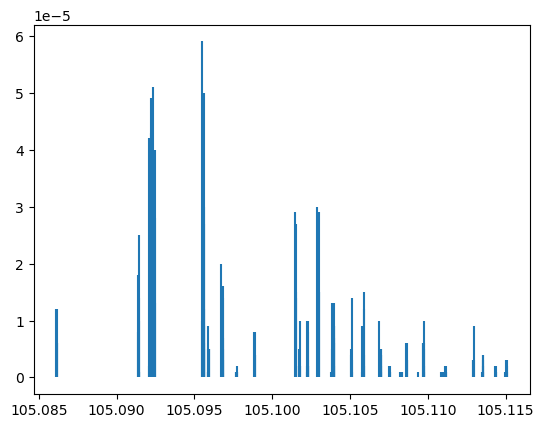

In [15]:
fig, ax = plt.subplots(1, 1)

ax.vlines('dE', 0, 'osc', data=spec.df)
plt.show()

In [16]:
spec.df

,i_state,f_state,osc,source,dE,f,i
idx,,,,,,,
0,1,3,0.000012,data/spectrum/part1.log,105.086119,2,0
1,2,5,0.000012,data/spectrum/part1.log,105.086194,4,1
2,1,5,0.000006,data/spectrum/part1.log,105.086194,4,0
3,1,6,0.000006,data/spectrum/part1.log,105.086194,5,0
4,2,9,0.000018,data/spectrum/part1.log,105.091361,8,1
...,...,...,...,...,...,...,...
147,2,165,0.000001,data/spectrum/part2.log,105.114965,242,1
148,2,167,0.000003,data/spectrum/part2.log,105.115001,244,1
149,1,170,0.000003,data/spectrum/part2.log,105.115084,247,0


In [17]:
rasci_dir = '/Users/kirill/Documents/UW/Li_Group/CsPbCl3_Ln/calculations/rasci/ras-t1u_1s_3p-14_4f-10_5d/dipoles'

gdvlogs = glob.glob(os.path.join(rasci_dir, 'rasci_414s.*ano_cl*.log'))

space = MCSpace.from_space_spec(
    ras=(12, 14, 10),
    elec=13,
    max_hole=2, max_elec=1,
    mo_blocks={
        '1s': [(0, 6)],
        '3p': [(6, 12)],
        '4f': [(12, 26)],
        '5d': [(26, 36)],
    },
)

spec_parts = []
for gdvlog in gdvlogs:
    part_data = parse_gdvlog(gdvlog, l910_parser_funcs, n_ground=14)
    spec = MCSpectrum.from_dict(part_data, space=space, sort_peaks=True)
    spec_parts.append(spec)

spec_parts = sorted(spec_parts, key=lambda x: np.mean(x.energy_range))

Reading /Users/kirill/Documents/UW/Li_Group/CsPbCl3_Ln/calculations/rasci/ras-t1u_1s_3p-14_4f-10_5d/dipoles/rasci_414s.r1_t1u_2t1u.cut_105_30506.ce3p_casscf_sa14_14s_gb3lyp_ref.ano_cl.gdv_j14p.7527806.log
Parsing link l910
Executing: read_mc_spec
Executing: read_ci
Executing: read_pdm_diags
Executing: read_oscillator_strength
Reading /Users/kirill/Documents/UW/Li_Group/CsPbCl3_Ln/calculations/rasci/ras-t1u_1s_3p-14_4f-10_5d/dipoles/rasci_414s.r1_t1u_2t1u.cut_105_13379.ce3p_casscf_sa14_14s_gb3lyp_ref.ano_cl.gdv_j14p.7527806.log
Parsing link l910
Executing: read_mc_spec
Executing: read_ci
Executing: read_pdm_diags
Executing: read_oscillator_strength
Reading /Users/kirill/Documents/UW/Li_Group/CsPbCl3_Ln/calculations/rasci/ras-t1u_1s_3p-14_4f-10_5d/dipoles/rasci_414s.r1_t1u_2t1u.cut_105_21828.ce3p_casscf_sa14_14s_gb3lyp_ref.ano_cl.gdv_j14p.7527806.log
Parsing link l910
Executing: read_mc_spec
Executing: read_ci
Executing: read_pdm_diags
Executing: read_oscillator_strength
Reading /Users/k

In [18]:
MCSpectrum.from_spectra(spec_parts)

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer